In [1]:
%matplotlib inline
import bpy

import cv2
import pylab
import torch
from torch.autograd import Variable
import numpy as np
from generic_pose.utils import to_np, to_var

import matplotlib as mpl
import matplotlib.pyplot as plt

import time

import warnings; warnings.simplefilter('ignore')
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
from object_pose_utils.utils.display import *

In [3]:
from dense_fusion.network import PoseNetGlobal, PoseNet
model_checkpoint = '/home/bokorn/src/DenseFusion/trained_checkpoints/linemod/pose_model_9_0.01310166542980859.pth'

num_objects = 13 #number of object classes in the dataset
num_points = 500 #number of points on the input pointcloud


#estimator = PoseNetGlobal(num_points = num_points, 
#                          num_obj = num_objects)
estimator = PoseNet(num_points = num_points, 
                    num_obj = num_objects)
estimator.load_state_dict(torch.load(model_checkpoint))
estimator.cuda();

In [4]:
from object_pose_utils.datasets.linemod_dataset import LinemodDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.inplane_rotation_augmentation import InplaneRotator
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

object_id = 1
#object_list = [object_id]#$list(range(1,22))

output_format = [otypes.TRANSFORM_MATRIX, 
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES,
                 otypes.IMAGE_CROPPED,
                 otypes.IMAGE,
                 otypes.MODEL_POINTS_TRANSFORMED,
                 otypes.MODEL_POINTS,
                 otypes.OBJECT_LABEL,
                 ]
dataset_root = "/scratch/datasets/linemod/Linemod_preprocessed/"

linemod_dataset = LinemodDataset(dataset_root, 
                         mode = 'train',
                         object_list = [object_id], 
                         output_data = output_format,
                         add_syn_noise = False,
                         add_syn_background = False,
                         resample_on_error = True,
                         preprocessors = [InplaneRotator(0)],
                         postprocessors = [ImageNormalizer()],
                         image_size = [640, 480], num_points=num_points)



In [5]:
from model_renderer.pose_renderer import BpyRenderer
from object_pose_utils.datasets.sixdc_dataset import ply_vtx
renderer = BpyRenderer()

px = 325.26110
py = 242.04899
fx = 572.41140
fy = 573.57043

renderer.setCameraMatrix(fx, fy, px, py, 640, 480)
renderer.setDepth()
model_filename = '{}/models/obj_{:02d}.ply'.format(dataset_root, object_id)
renderer.deleteAll()
renderer.loadModel(model_filename, emit = 0.5, model_scale=1./1000)

model_cloud = ply_vtx(model_filename)/1000.
model_cloud = model_cloud[np.random.choice(len(model_cloud), 1000, replace=False)]


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_01.ply' in 0.655 sec


In [23]:
from quat_math import quaternion_matrix, random_quaternion

def getTransfrom(q, t=[0,0,0.5]):
    trans_mat = quaternion_matrix(q)
    trans_mat[:3,3] = t
    return trans_mat



Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_01.ply' in 0.617 sec


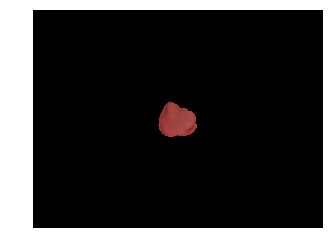


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_02.ply' in 3.517 sec


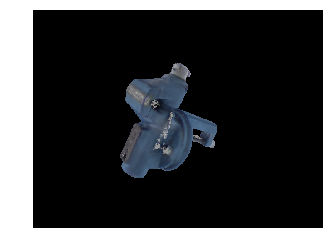


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_04.ply' in 1.644 sec


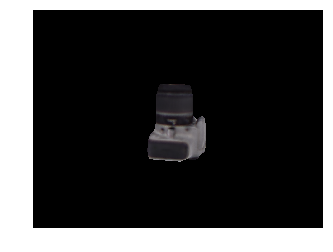


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_05.ply' in 2.110 sec


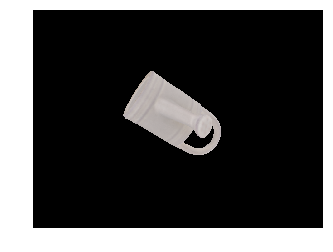


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_06.ply' in 1.653 sec


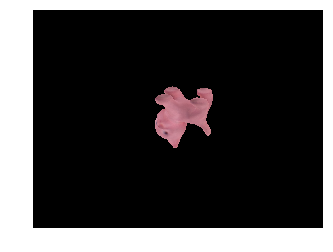


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_08.ply' in 1.175 sec


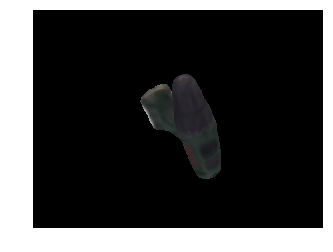


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_09.ply' in 0.779 sec


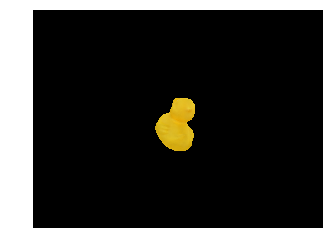


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_10.ply' in 1.602 sec


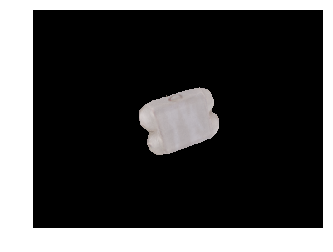


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_11.ply' in 0.718 sec


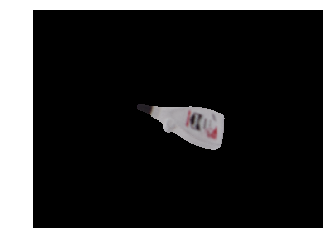


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_12.ply' in 1.381 sec


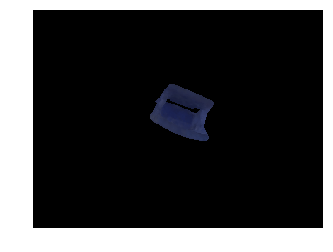


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_13.ply' in 1.724 sec


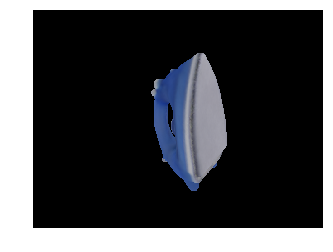


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_14.ply' in 2.299 sec


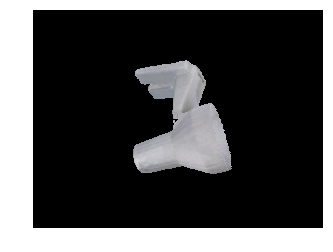


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_15.ply' in 1.533 sec


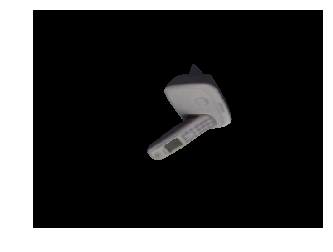

In [25]:
for object_id in [1,2,4,5,6,8,9,10,11,12,13,14,15]:
    model_filename = '{}/models/obj_{:02d}.ply'.format(dataset_root, object_id)
    renderer.deleteAll()
    renderer.loadModel(model_filename, emit = 0.5, model_scale=1./1000)

    img, _ = renderer.renderTrans(getTransfrom(random_quaternion(), [0,0,.5]))
    imshowCV(img)

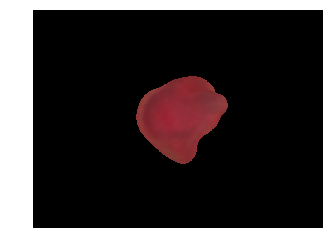

In [21]:
imshowCV(img)

In [ ]:
ls /ssd0/datasets/ycb/YCB_Video_Dataset/depth_renders/003_cracker_box/00

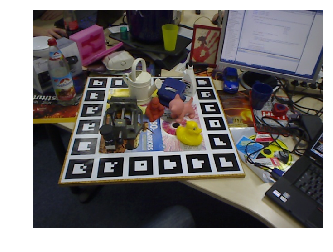

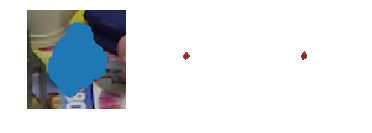

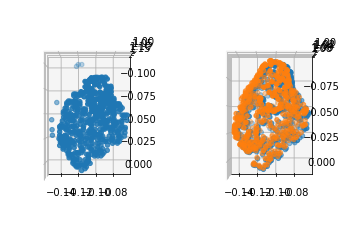

In [6]:
from object_pose_utils.utils.pose_error import add, adi, transform_pts_Rt
from quat_math import euler_matrix, quaternion_matrix, quaternion_about_axis, quaternion_from_matrix


idx = 0
mat, points1, choose1, img1, img_full, target, model_points, obj1 = linemod_dataset[idx]
imshowTorch(img_full, normalized=True, show=True)

obj1 = obj1 - 1
points1, choose1, img1, target, model_points, obj1 = Variable(points1.unsqueeze(0)).cuda(), \
                                                 Variable(choose1.unsqueeze(0)).cuda(), \
                                                 Variable(img1.unsqueeze(0)).cuda(), \
                                                 Variable(target.unsqueeze(0)).cuda(), \
                                                 Variable(model_points.unsqueeze(0)).cuda(), \
                                                 Variable(obj1.unsqueeze(0)).cuda()

pred_r, pred_t, pred_c, emb = estimator(img1, points1, choose1, obj1)

how_max, which_max = torch.max(pred_c, 1)
pred_t = points1[0] + pred_t[0,:]
pred_q = pred_r[0,:,[1,2,3,0]]
pred_q /= torch.norm(pred_q, dim=1).view(-1,1)
max_c = to_np(how_max)
max_q = to_np(pred_q[which_max.item()])
max_t = to_np(pred_t[which_max.item()])

pred_mat = quaternion_matrix(max_q)
pred_mat[:3,3] = max_t

model_cloud = to_np(model_points[0])
mat = to_np(mat)
err = add(mat[:3,:3], mat[:3,3], pred_mat[:3,:3], pred_mat[:3,3], model_cloud)

if(True):
    plt.subplot(131)
    plotImageScatter(torch2Img(img1[0], normalized=True), to_np(choose1[0]), show=False)
    plt.subplot(132)
    image_rend, depth_rend = renderer.renderTrans(mat)
    image_rend[:,:,:3] = cv2.cvtColor(image_rend[:,:,:3], cv2.COLOR_BGR2RGB)
    imshow(image_rend, show=False)
    plt.subplot(133)
    image_rend, depth_rend = renderer.renderTrans(pred_mat)
    image_rend[:,:,:3] = cv2.cvtColor(image_rend[:,:,:3], cv2.COLOR_BGR2RGB)
    imshow(image_rend, show=False)
    plt.show()

    ax = plt.subplot(121, projection='3d')
    pts_np = to_np(points1[0])
    ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
    ax.view_init(270, -90)

    ax = plt.subplot(122, projection='3d')
    pts_np = transform_pts_Rt(model_cloud, mat[:3,:3], mat[:3,3])
    ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
    pts_np = transform_pts_Rt(model_cloud, pred_mat[:3,:3], pred_mat[:3,3])
    ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
    ax.view_init(270, -90)

    plt.show()


In [22]:
len(dataset)

97


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_01.ply' in 0.450 sec


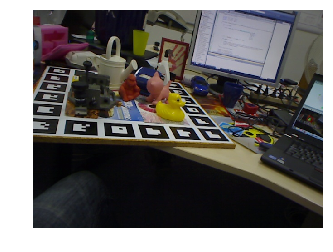

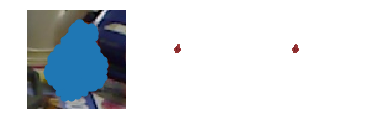

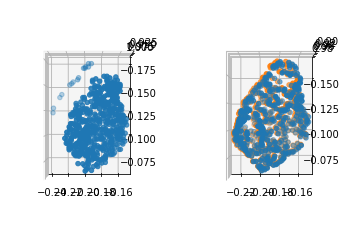


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_02.ply' in 3.606 sec


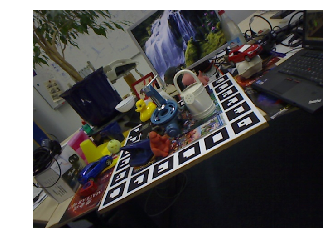

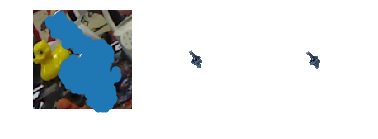

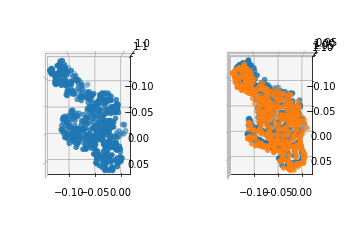


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_04.ply' in 1.481 sec


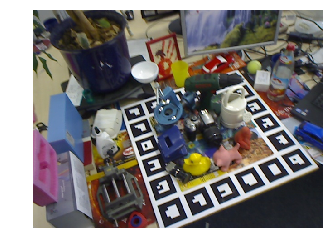

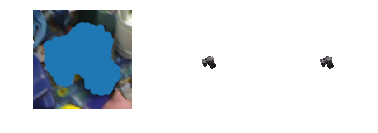

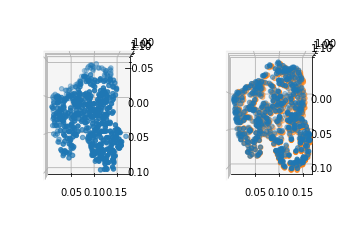


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_05.ply' in 2.580 sec


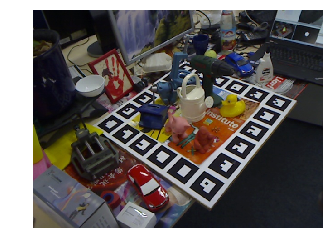

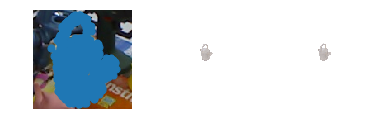

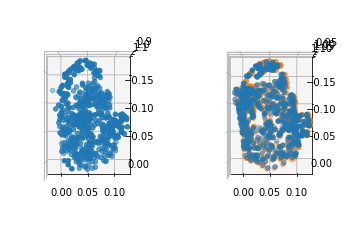


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_06.ply' in 1.389 sec


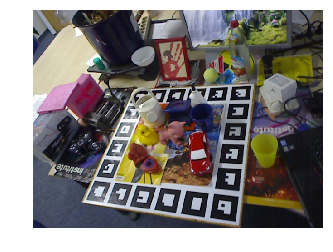

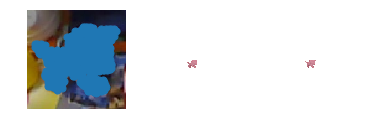

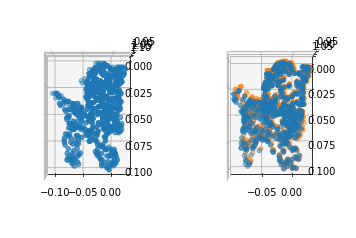


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_08.ply' in 1.193 sec


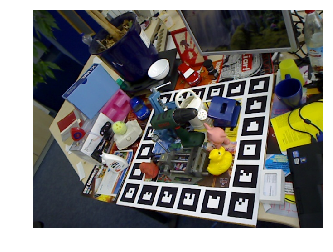

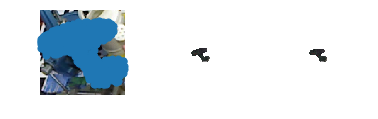

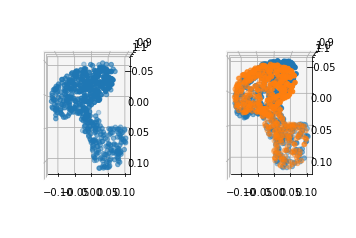


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_09.ply' in 0.757 sec


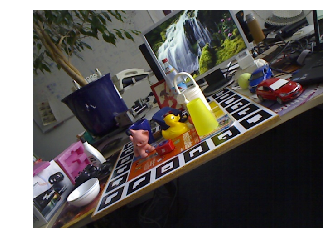

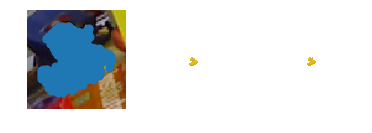

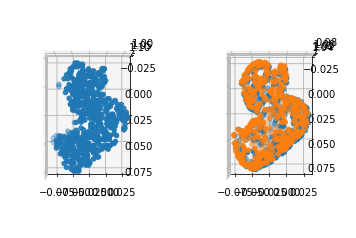


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_10.ply' in 1.549 sec


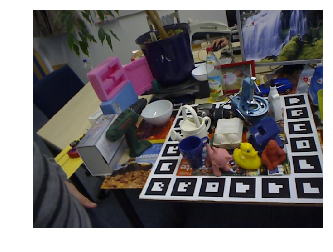

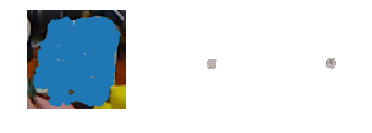

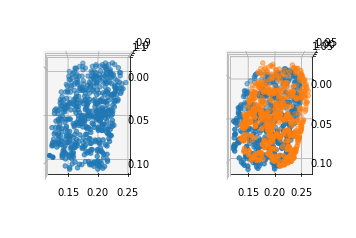


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_11.ply' in 0.679 sec


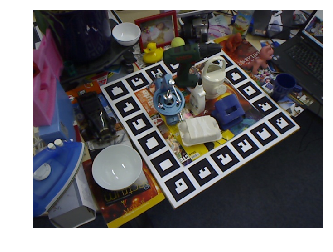

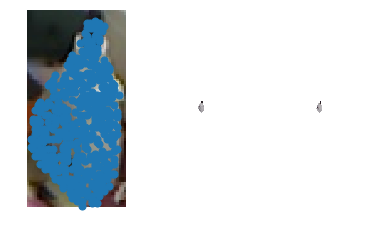

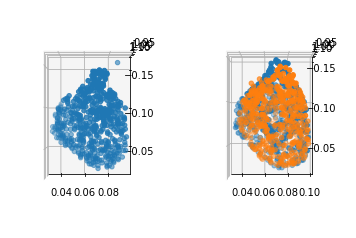


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_12.ply' in 1.170 sec


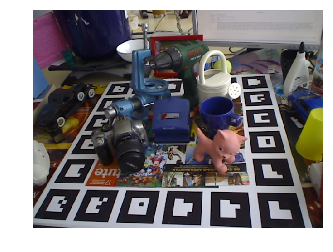

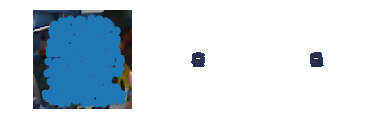

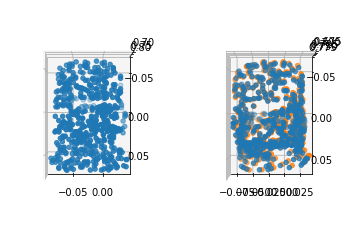


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_13.ply' in 1.921 sec


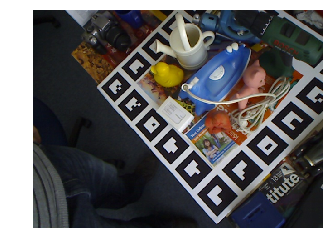

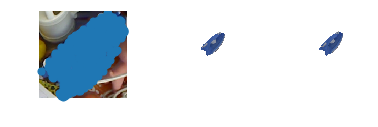

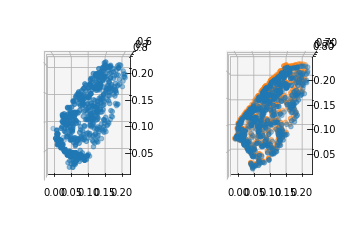


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_14.ply' in 2.504 sec


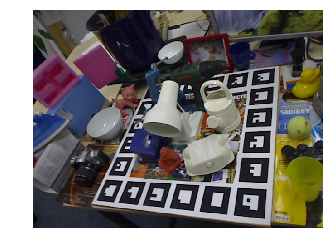

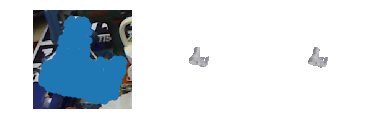

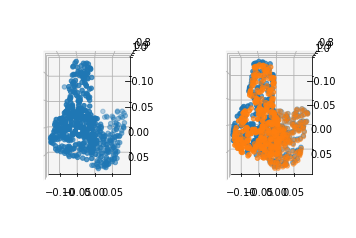


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_15.ply' in 1.408 sec


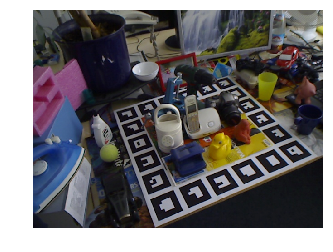

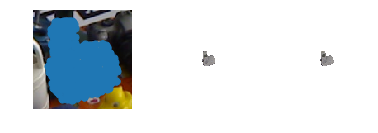

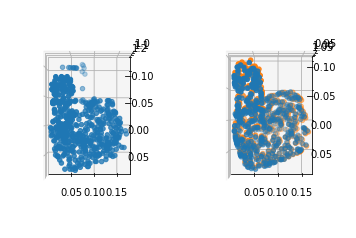

In [32]:
from object_pose_utils.utils.pose_error import add, adi, transform_pts_Rt
from quat_math import euler_matrix, quaternion_matrix, quaternion_about_axis, quaternion_from_matrix

for object_id in [1,2,4,5,6,8,9,10,11,12,13,14,15]:
    dataset = LinemodDataset(dataset_root, 
                             mode = 'train',
                             segnet_masks = False,
                             object_list = [object_id], 
                             output_data = output_format,
                             add_syn_noise = False,
                             add_syn_background = False,
                             resample_on_error = True,
                             postprocessors = [ImageNormalizer()],
                             image_size = [640, 480], num_points=num_points)

    model_filename = '{}/models/obj_{:02d}.ply'.format(dataset_root, object_id)
    renderer.deleteAll()
    renderer.loadModel(model_filename, emit = 0.5, model_scale=1./1000)

    model_cloud = ply_vtx(model_filename)/1000.
    model_cloud = model_cloud[np.random.choice(len(model_cloud), 1000, replace=False)]

    for idx in [10]:#range(0,len(dataset), 50):
        mat, points, choose, img, img_full, target, model_points, obj = dataset[idx]
        imshowTorch(img_full, normalized=True, show=True)

        obj = torch.nonzero(torch.LongTensor(dataset.object_labels) == obj)[0]

        points, choose, img, target, model_points, obj = Variable(points.unsqueeze(0)).cuda(), \
                                                         Variable(choose.unsqueeze(0)).cuda(), \
                                                         Variable(img.unsqueeze(0)).cuda(), \
                                                         Variable(target.unsqueeze(0)).cuda(), \
                                                         Variable(model_points.unsqueeze(0)).cuda(), \
                                                         Variable(obj.unsqueeze(0)).cuda()

        pred_r, pred_t, pred_c, emb = estimator(img, points, choose, obj)

        how_max, which_max = torch.max(pred_c, 1)
        pred_t = points[0] + pred_t[0,:]
        pred_q = pred_r[0,:,[1,2,3,0]]
        pred_q /= torch.norm(pred_q, dim=1).view(-1,1)
        max_c = to_np(how_max)
        max_q = to_np(pred_q[which_max.item()])
        max_t = to_np(pred_t[which_max.item()])
        
        pred_mat = quaternion_matrix(max_q)
        pred_mat[:3,3] = max_t
        
        model_cloud = to_np(model_points[0])
        mat = to_np(mat)
        
        err = add(mat[:3,:3], mat[:3,3], pred_mat[:3,:3], pred_mat[:3,3], model_cloud)

        if(True):
            plt.subplot(131)
            plotImageScatter(torch2Img(img[0], normalized=True), to_np(choose[0]), show=False)
            plt.subplot(132)
            image_rend, depth_rend = renderer.renderTrans(mat)
            image_rend[:,:,:3] = cv2.cvtColor(image_rend[:,:,:3], cv2.COLOR_BGR2RGB)
            imshow(image_rend, show=False)
            plt.subplot(133)
            image_rend, depth_rend = renderer.renderTrans(pred_mat)
            image_rend[:,:,:3] = cv2.cvtColor(image_rend[:,:,:3], cv2.COLOR_BGR2RGB)
            imshow(image_rend, show=False)
            plt.show()

            ax = plt.subplot(121, projection='3d')
            pts_np = to_np(points[0])
            ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
            ax.view_init(270, -90)

            ax = plt.subplot(122, projection='3d')
            pts_np = transform_pts_Rt(model_cloud, mat[:3,:3], mat[:3,3])
            ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
            pts_np = transform_pts_Rt(model_cloud, pred_mat[:3,:3], pred_mat[:3,3])
            ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
            ax.view_init(270, -90)

            plt.show()



Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_01.ply' in 0.409 sec


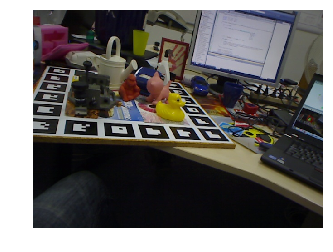

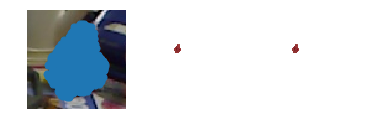

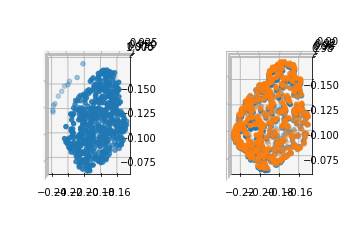


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_02.ply' in 3.300 sec


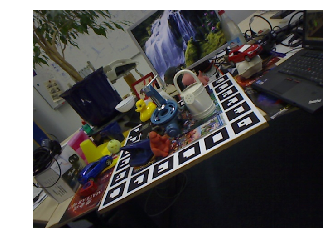

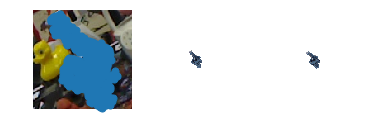

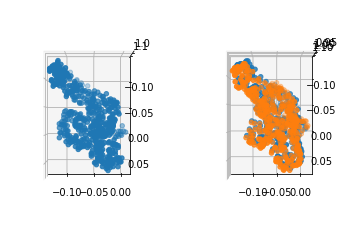


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_04.ply' in 1.803 sec


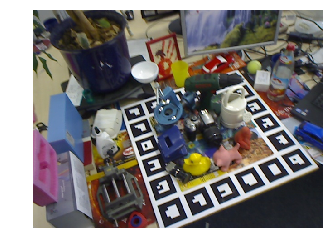

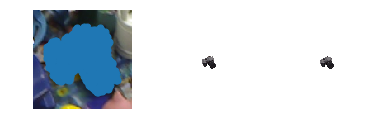

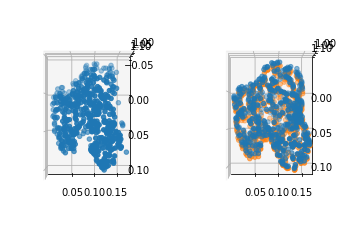


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_05.ply' in 2.471 sec


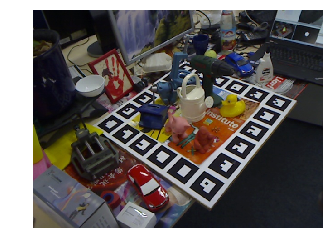

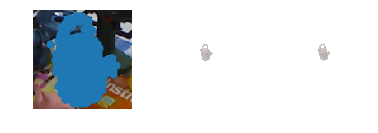

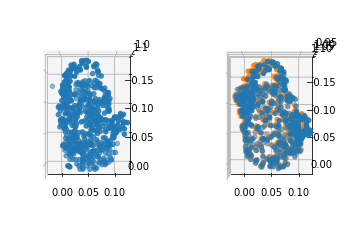


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_06.ply' in 1.417 sec


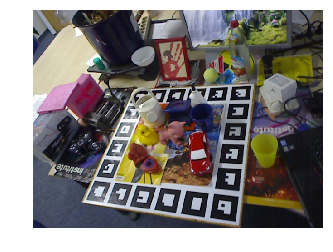

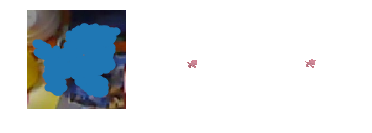

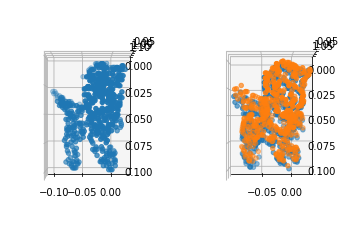


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_08.ply' in 1.060 sec


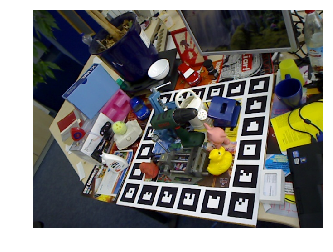

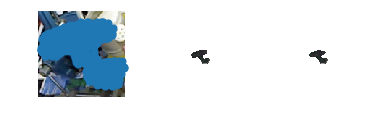

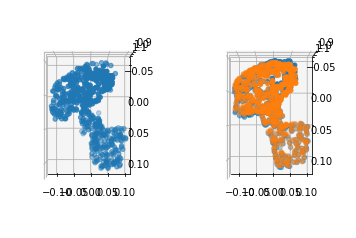


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_09.ply' in 0.527 sec


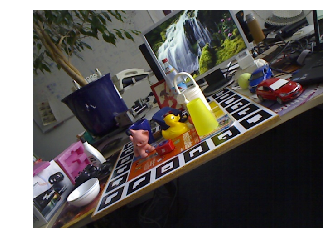

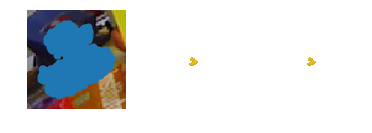

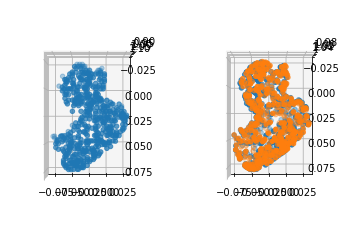


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_10.ply' in 1.520 sec


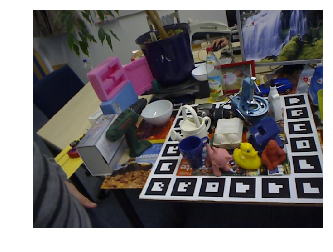

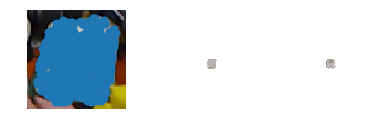

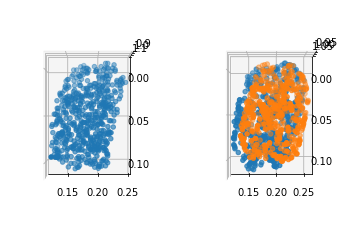


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_11.ply' in 0.594 sec


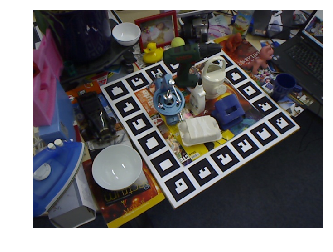

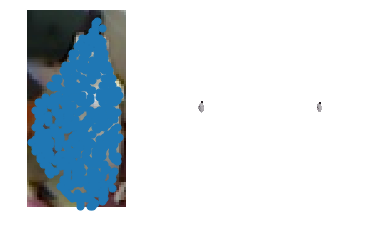

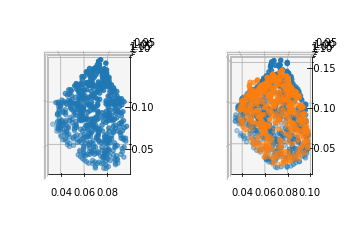


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_12.ply' in 1.528 sec


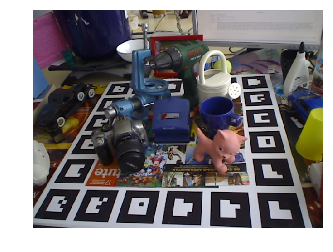

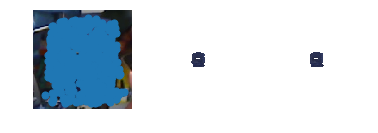

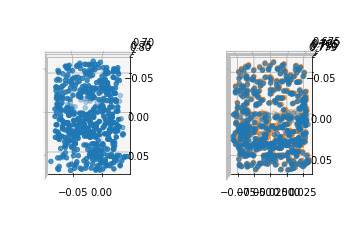


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_13.ply' in 1.570 sec


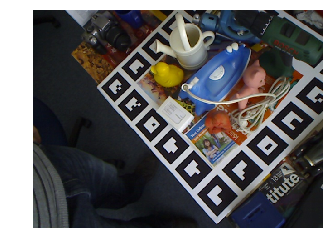

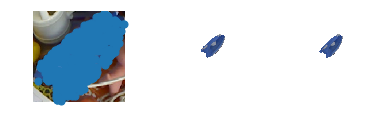

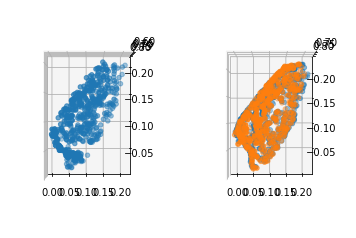


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_14.ply' in 2.528 sec


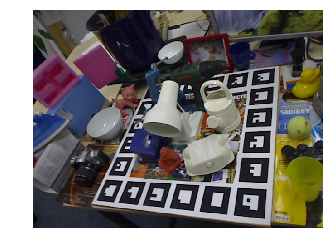

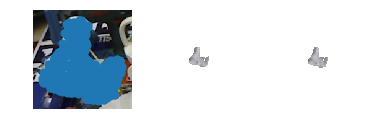

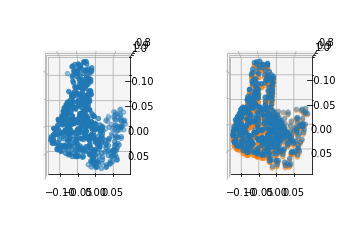


Successfully imported '/scratch/datasets/linemod/Linemod_preprocessed//models/obj_15.ply' in 1.719 sec


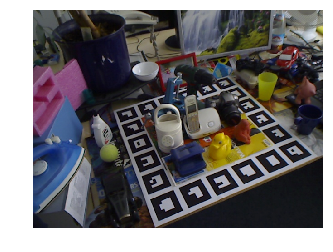

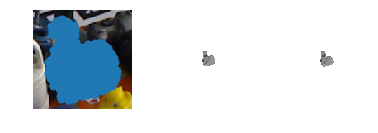

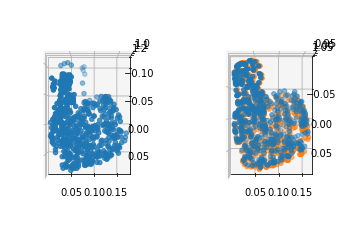

In [33]:
from object_pose_utils.utils.pose_error import add, adi, transform_pts_Rt
from quat_math import euler_matrix, quaternion_matrix, quaternion_about_axis, quaternion_from_matrix
from generic_pose.utils.evaluation_utils import fullEvaluateDenseFusion

for object_id in [1,2,4,5,6,8,9,10,11,12,13,14,15]:
    dataset = LinemodDataset(dataset_root, 
                             mode = 'train',
                             segnet_masks = False,
                             object_list = [object_id], 
                             output_data = output_format,
                             add_syn_noise = False,
                             add_syn_background = False,
                             resample_on_error = True,
                             postprocessors = [ImageNormalizer()],
                             image_size = [640, 480], num_points=num_points)

    model_filename = '{}/models/obj_{:02d}.ply'.format(dataset_root, object_id)
    renderer.deleteAll()
    renderer.loadModel(model_filename, emit = 0.5, model_scale=1./1000)

    model_cloud = ply_vtx(model_filename)/1000.
    model_cloud = model_cloud[np.random.choice(len(model_cloud), 1000, replace=False)]

    for idx in [10]:#range(0,len(dataset), 50):
        mat, points, choose, img, img_full, target, model_points, obj = dataset[idx]
        imshowTorch(img_full, normalized=True, show=True)

        #obj = torch.nonzero(torch.LongTensor(dataset.object_labels) == obj)[0]
        obj = torch.nonzero(torch.LongTensor(dataset.object_labels) == obj)[0] + 1

        res = fullEvaluateDenseFusion(estimator, img, points, choose, obj)
        max_q, max_t, max_c, max_feat, pred_q, pred_t, pred_c, refine_q, refine_t, global_feat = res

        pred_mat = quaternion_matrix(max_q)
        pred_mat[:3,3] = max_t
        
        model_cloud = to_np(model_points)
        mat = to_np(mat)
        
        err = add(mat[:3,:3], mat[:3,3], pred_mat[:3,:3], pred_mat[:3,3], model_cloud)

        if(True):
            plt.subplot(131)
            plotImageScatter(torch2Img(img, normalized=True), to_np(choose), show=False)
            plt.subplot(132)
            image_rend, depth_rend = renderer.renderTrans(mat)
            image_rend[:,:,:3] = cv2.cvtColor(image_rend[:,:,:3], cv2.COLOR_BGR2RGB)
            imshow(image_rend, show=False)
            plt.subplot(133)
            image_rend, depth_rend = renderer.renderTrans(pred_mat)
            image_rend[:,:,:3] = cv2.cvtColor(image_rend[:,:,:3], cv2.COLOR_BGR2RGB)
            imshow(image_rend, show=False)
            plt.show()

            ax = plt.subplot(121, projection='3d')
            pts_np = to_np(points)
            ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
            ax.view_init(270, -90)

            ax = plt.subplot(122, projection='3d')
            pts_np = transform_pts_Rt(model_cloud, mat[:3,:3], mat[:3,3])
            ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
            pts_np = transform_pts_Rt(model_cloud, pred_mat[:3,:3], pred_mat[:3,3])
            ax.scatter(pts_np[:,0], pts_np[:,1], pts_np[:,2])
            ax.view_init(270, -90)

            plt.show()


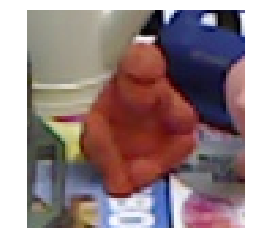